# Running Centernet with ResneXt-50_32 , 4 epochs, loss function = Binary Crossentroy, Ignore Mask is used, Heatmap is simple non-gaussian type

In [1]:
KAGGLE = True
COLAB = False

MAKE_SUBMISSION_BATCH_SIZE = 4
DEV_PREDICTIONS_BATCH_SIZE = 4

# SPECIFY THE MODEL PATH BELOW BEFORE RUNNING

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

import albumentations as alb

from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
#from multiprocessing import Pool

import torch.utils.model_zoo as model_zoo
import gc
#from torch.hub import load_state_dict_from_url

In [3]:
## KAGGLE and COLAB flags should not be True at same time - fail if this is case
assert not (KAGGLE and COLAB), "both KAGGLE and COLAB runs cannot be true"

In [4]:
if KAGGLE and not COLAB:          #  kaggle run
    HOMEDIR = r'../input/pku-autonomous-driving/'
    OUTDIR = r'./'
    
elif COLAB and not KAGGLE:         # google colab
    from google.colab import drive
    drive.mount('/content/drive')
    #
    HOMEDIR = r'/content/drive/My Drive/baidu/pku-autonomous-driving/'
    OUTDIR = r'./content/drive/My Drive/baidu/pku-autonomous-driving/outputROHIT/'

elif not KAGGLE and not COLAB:
    HOMEDIR = r"/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/CaseStudy2/Kaggle-PekingAutonomousDriving/pku-autonomous-driving/"
    OUTDIR = r"/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/CaseStudy2/Kaggle-PekingAutonomousDriving/pku-autonomous-driving/output/"

#
if COLAB: print(f"COLAB")
if KAGGLE: print(f"KAGGLE")
if not (KAGGLE and COLAB): print(f"not CLOUD")

print(f"HOMEDIR =\n{HOMEDIR}\nOUTDIR=\n{OUTDIR}")

KAGGLE
not CLOUD
HOMEDIR =
../input/pku-autonomous-driving/
OUTDIR=
./


In [5]:
## resneXt-50_32 centernet , 4 epochs , bct loss , with mask images
model_path = r'../input/mysavedmodel/model_rohit_resneXt_bct_Mask_20200308_0526.pth'

In [6]:
os.listdir(HOMEDIR)

['train.csv',
 'train_images',
 'car_models',
 'camera',
 'train_masks',
 'test_images',
 'test_masks',
 'car_models_json',
 'sample_submission.csv']

# Basic info loading

## data, camera matrix specification


## train.csv   has   ImageId, PredictionString

## Prediction String    model# yaw pitch roll x y z  and the same for multiple cars

In [7]:
dfTrain = pd.read_csv(HOMEDIR + 'train.csv')
dfTest = pd.read_csv(HOMEDIR + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)

In [8]:
dfTrain.head()

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


In [9]:
bad_images_list = ["ID_1a5a10365","ID_4d238ae90","ID_408f58e9f","ID_bb1d991f6","ID_c44983aeb"]

print(f"full df len = {len(dfTrain)}")
drop_dfTrain = dfTrain.set_index("ImageId").drop( index=bad_images_list )
dfTrain = drop_dfTrain.reset_index()
print(f"post removal of bad entries len = {len(dfTrain)}")

full df len = 4262
post removal of bad entries len = 4257


# Set swtich for very small data run

In [10]:
TEST_SWITCH_ON = False

In [11]:
if TEST_SWITCH_ON:
    dfTrain = dfTrain[:250]
    dfTest  = dfTest[:50]

In [12]:
def str2coords(ps, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
# from the prediction string entries, create a dict of each car data
    coords = []
    for ps_entry in np.array(ps.split()).reshape([-1, 7]):
        dictval = dict(zip(names, ps_entry.astype('float')))
        coords.append(dictval)
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [13]:
inp = dfTrain['PredictionString'][0]
print(f"ps =\n{inp}")
print()
print(f"Output =\n{str2coords(inp)}")

ps =
16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output =
[{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


# 2D Visualization

In [14]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

In [15]:
def read_image(path):
    img = cv2.imread(path)
    #img = np.array(img[:, :, ::-1]) # alternative way to convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    return img

In [16]:
def convert_to_img_coords(ps):
# convert the camera coords x,y,z to the image coords
    coords = str2coords(ps)
    x_list = [c['x'] for c in coords]
    y_list = [c['y'] for c in coords]
    z_list = [c['z'] for c in coords]
    P = np.array(list(zip(x_list, y_list, z_list))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_x_list = img_p[:, 0]
    img_y_list = img_p[:, 1]
    img_z_list = img_p[:, 2]
    return img_x_list, img_y_list

# 3D Visualization

In [17]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [18]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

# Average ratios of the spanX, spanY and spanZ  by groups decided by me

GroupNo based on Z / X value bin.
GroupNo     Xspan       Yspan       Zspan       Yspan/Xspan     Zspan/Xspan
1           1.96        1.58        3.78		0.80            1.92
2           2.08        1.65        4.49        0.80            2.15
3           2.03        1.57        4.86        0.78            2.38

average of all these
GroupNo     Xspan       Yspan       Zspan       Yspan/Xspan     Zspan/Xspan
            1.00        0.79        2.15        0.79            2.15

In [19]:
def visualize(img, coords):
    ## want to visualize 
    x_l = 1.00
    y_l = 0.79
    z_l = 2.15
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        ## the yaw and pitch is interchanged in the data provided
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

# Steps to preprocess input image

In [20]:
# Original dimensions of the Train and Test images
ORIG_W = 3384
ORIG_H = 2710

# The dimensions we want to use for processing: keeping ratio of width:height = 1:4
IMG_WIDTH = 2048
IMG_HEIGHT = 512
MARGIN_W = ORIG_W // 4  # 846

MODEL_SCALE = 8  # mask shrink rate

FX, FY = 2304.5479,  2305.8757
CX, CY = 1686.2379, 1354.9849
def XYZ2UV(x,y,z):
    u = FX * x / z + CX
    v = FY * y / z + CY
    return u,v
def UVZ2XY(u,v,z):
    x = z * (u - CX) / FX
    y = z * (v - CY) / FY
    return x,y

#
# u is horizontal dimension and v is vertical dimension
#
def VU2maskVU(v,u):  
    mask_V = (v - ORIG_H // 2) * IMG_HEIGHT / (ORIG_H // 2) / MODEL_SCALE
    mask_U = (u + MARGIN_W) * IMG_WIDTH  / (ORIG_W + 2*MARGIN_W) / MODEL_SCALE
    return mask_V, mask_U
def maskVU2VU(mask_v_float, mask_u_float):
    v = ORIG_H // 2 + mask_v_float * MODEL_SCALE / IMG_HEIGHT * (ORIG_H // 2)
    u = mask_u_float * MODEL_SCALE * (ORIG_W + 2*MARGIN_W) / IMG_WIDTH - MARGIN_W
    return v, u

## assertion usage
REGR_TARGETS = sorted( ["yaw","pitch_sin", "pitch_cos", "roll", "udiff", "vdiff", "z"] )
def _regr_preprocess(regr_dict, vdiff, udiff):
    """ vdiff(h orientation), udiff is regression target """
    regr_dict["vdiff"] = vdiff
    regr_dict["udiff"] = udiff

    # Roll
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    
    # Pitch
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])

    # Regress log(Z)
    regr_dict["z"] = np.log(regr_dict["z"])
    
    regr_dict.pop('x')
    regr_dict.pop('y')
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict, mask_V_pos, mask_U_pos):
    # convert log(z) back to z
    regr_dict["z"] = np.exp(regr_dict["z"])

    _v, _u = maskVU2VU( mask_V_pos + regr_dict["vdiff"], mask_U_pos + regr_dict["udiff"] )
    regr_dict["x"], regr_dict["y"] = UVZ2XY(_u, _v, regr_dict["z"])

    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)

    ## Pitch
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :MARGIN_W]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def preprocess_mask_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.zeros_like(img).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # linear interpolate
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = convert_to_img_coords(labels)
    z_arr = [e["z"] for e in coords]
    
    mask_V_arr_float, mask_U_arr_float = VU2maskVU( ys, xs )

    # florring and keeping track of the difference to use it later during _regr_back process
    mask_V_arr = np.floor( mask_V_arr_float ).astype('int')
    mask_U_arr = np.floor( mask_U_arr_float ).astype('int')
    mask_V_diff = mask_V_arr_float - mask_V_arr
    mask_U_diff = mask_U_arr_float - mask_U_arr
    
    for mask_V,mask_U, vdiff,udiff, regr_dict in zip(mask_V_arr,mask_U_arr,mask_V_diff,mask_U_diff, coords):
        if mask_V >= 0 and mask_V < IMG_HEIGHT // MODEL_SCALE and mask_U >= 0 and mask_U < IMG_WIDTH // MODEL_SCALE:
            ## make heatmap
            mask[mask_V, mask_U] = 1  ## no gaussian usage for GT heatmaps
            
            regr_dict = _regr_preprocess(regr_dict, vdiff, udiff)
            regr[mask_V, mask_U] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

In [21]:
def vis_mask(img, mask):
    _mm = np.repeat( np.repeat(mask, 8, axis=0), 8, axis=1 )[:,:, None]
    _mm = np.repeat(_mm, 3, axis=-1)
    _mm [:,:,1] = 0 ; _mm[:,:,2] = 0
    
    tmp =  np.clip( 0.8 * img + 0.4 * _mm, 0,1)
    tmp[ _mm[:,:,0]==1 ] = [0,1,1]
    plt.figure(figsize=(16,16))
    plt.imshow( tmp , alpha=0.3)
    plt.grid()
    plt.show()


# PyTorch Dataset

In [22]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, mask_root_dir, training=True):
        self.df = dataframe
        self.root_dir = root_dir
        self.mask_root_dir = mask_root_dir  # ignore mask
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        ## Read image
        img0 = cv2.imread(img_name)[:,:,::-1]
        img = preprocess_image(img0.astype(float))
        img = np.rollaxis(img, 2, 0)
        
        ## Read ignore mask
        ign_img0 = cv2.imread(self.mask_root_dir.format(idx), cv2.IMREAD_GRAYSCALE)
        if ign_img0 is None:  # where there is no mask image available
            ign_img0 = np.zeros((ORIG_H, ORIG_W), dtype='float32')

        ign_img = np.array(ign_img0).astype('float32') / 255.

        # ignore mask for CNN
        ign_img_for_feed = preprocess_mask_image(ign_img0)
        ign_img_for_feed = np.expand_dims(ign_img_for_feed, 0)  # h,w -> 1,h,w
        
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr, ign_img, ign_img_for_feed]

In [23]:
train_images_dir = HOMEDIR + 'train_images/{}.jpg'
test_images_dir = HOMEDIR + 'test_images/{}.jpg'
train_masks_dir = HOMEDIR + 'train_masks/{}.jpg'
test_masks_dir = HOMEDIR + 'test_masks/{}.jpg'

df_train, df_dev = train_test_split(dfTrain, test_size=0.1, random_state=1042)
df_test = dfTest

## Create objects of the class type Dataset -  one for each data set
train_dataset = CarDataset(df_train, train_images_dir, train_masks_dir)
dev_dataset = CarDataset(df_dev, train_images_dir, train_masks_dir)
test_dataset = CarDataset(df_test, test_images_dir, test_masks_dir)

In [24]:
BATCH_SIZE = 1

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# PyTorch Model

In [25]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [26]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.utils.model_zoo as model_zoo

#__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
#           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
#           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, input_channels=3):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(input_channels, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)  #herre

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    '''def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)'''

    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [27]:
#base_model = resnext50_32x4d(pretrained=True)
#base_model

In [28]:
USEMASK = True

class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
        self.base_model = resnext50_32x4d(pretrained=False, input_channels=6)
        
        # Lateral layers convert resnet outputs to a common feature size
        self.lat8 = nn.Conv2d(512, 256, 1)
        self.lat16 = nn.Conv2d(1024, 256, 1)
        self.lat32 = nn.Conv2d(2048, 256, 1)
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

        if USEMASK:
            self.conv0 = double_conv(5 + 1, 64)
        else:
            self.conv0 = double_conv(5, 64)
            
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 , 512) #+ 1024
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        #feats = self.base_model.extract_features(x)
                # Run frontend network
        if USEMASK:
            ## feats8, feats16, feats32 = self.base_model(x[:,0:3])  ## use first 3 channel. this may not be proper way
            feats8, feats16, feats32 = self.base_model(x0)  ## C=6 : rgb(3)+mask(1)+mesh(2)
        else:
            feats8, feats16, feats32 = self.base_model(x)

        lat8 = F.relu(self.bn8(self.lat8(feats8)))
        lat16 = F.relu(self.bn16(self.lat16(feats16)))
        lat32 = F.relu(self.bn32(self.lat32(feats32)))
        
        # Add positional info
        mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        feats = torch.cat([lat32, mesh2], 1)
        #print(feats.shape)
        #print (x4.shape)
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

# Load the saved model

In [29]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)


cuda


In [30]:
saved_model = CentResnet(8).to(device)

In [31]:
## resneXt-50_32 centernet , 4 epochs , bct loss , with mask images
#model_path = r"/home/rohit/SRH/CaseStudy2/Models/Cent-ResneXt/model_rohit_resneXt_bct_Mask_20200308_0526.pth"


In [32]:
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [33]:
saved_model.eval()

CentResnet(
  (base_model): ResNet(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

In [34]:
model = saved_model

In [35]:
type(model)

__main__.CentResnet

# Load the model and continue the rest

In [36]:
USEMASK

True

In [37]:
def infer_image(img, ign_mask_for_feed):  # shape:[B,C,H,W]
    return model( torch.from_numpy( np.concatenate((img, ign_mask_for_feed),axis=1) ).to(device) )

In [38]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## max-pool to find the highest values for prob(pixel position = center) based on its own and the 8 surrounding pixels in heatmap
# match up the max-pool with the original position in predicted heatmap and retain only if above threshold
def postprocess_heatmap(logits, thresh=0.45):
    prob = sigmoid(logits)
    mp2d = torch.nn.MaxPool2d(3, stride=1, padding=1, dilation=1, return_indices=False, ceil_mode=False)
    out = mp2d( torch.Tensor([[prob]]) ).numpy()[0][0]
    return (prob == out) & (prob > thresh)

In [39]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # taken from here: https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2

    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction, ign_mask):
    assert ign_mask.shape[0] == ORIG_H   #
    logits = prediction[0]
    regr_output = prediction[1:]
    
    points_mat = postprocess_heatmap(logits) 
    points = np.argwhere( points_mat > 0 )
    
    col_names = sorted(REGR_TARGETS)  #pitch_sin,pitch_cos,roll, udiff,vdiff,yaw,z
    coords = []
    for r, c in points:           
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        
        # use heatmap-peak (V,U) position
        regr_backed = _regr_back(regr_dict, r, c)
        
        _U, _V = XYZ2UV(regr_backed["x"], regr_backed["y"], regr_backed["z"])
        _U, _V = int(_U), int(_V)
        if _V>=0 and _V<ORIG_H and _U>=0 and _U<ORIG_W and ign_mask[_V,_U] > 0.5:  # floor(u), floor(v)
            # print("point is in ignore_mask")
            continue

        coords.append(regr_backed)
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))

        coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

# mAP calculation

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from multiprocessing import Pool
import functools

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    assert len(PredictionStringCols) == 7
    idarr = []
    tmparr = []
    for imgid, predstr in zip( df['ImageId'], df['PredictionString']):
        if predstr == "":
            continue
        coords = np.array(predstr.split(' ')).reshape(-1,7).astype(float)
        for cor in coords:
            idarr.append(imgid)
            tmparr.append(  cor.tolist() )
    
    prediction_strings_expanded = np.array(tmparr)
    df = pd.DataFrame(
        {
            'ImageId': idarr,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def str2coords_dev(s, names):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords

def TranslationDistance(p,g, abs_dist = False):
    deltax = p['x'] - g['x']
    deltay = p['y'] - g['y']
    deltaz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (deltax**2 + deltay**2 + deltaz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

In [41]:
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(train_df, valid_df, idx):  # train_df==TrueLabel, valid_df==Prediction
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords_dev(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords_dev(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores


In [42]:
_train_df = pd.read_csv(HOMEDIR + 'train.csv')
def calc_map(valid_df):
    if np.all( valid_df.dropna().PredictionString == "" ):  # no pred
        #print("warn: no prediction")
        return 0.0

    expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])

    val_label_df = _train_df[_train_df.ImageId.isin(valid_df.ImageId.unique())]
    # kaggle data description page says prediction string is:
    ## model_id, yaw, pitch, roll, x, y, z
    # BUT it seems to be wrong, confirmed by discussion thread. Actually its:
    # model_id, pitch, yaw, roll, x, y, z
    expanded_val_label_df = expand_df(val_label_df, ['model_type','pitch','yaw','roll','x','y','z'])

    n_gt = len(expanded_val_label_df)
    ap_list = []

    eval_func = functools.partial(check_match, val_label_df, valid_df)

    for _i in range(10):
        result_flg, scores = eval_func(_i)

        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt

        ### randomized score version
        ### https://www.kaggle.com/c/pku-autonomous-driving/discussion/124489
        # ap = average_precision_score(result_flg, scores)*recall
        if False:
            ap = average_precision_score(result_flg, np.random.rand(len(result_flg)))*recall
        else: # pure precision * recall
            ap = np.mean(result_flg) * recall
            # print(f"precision/recall/F1 {np.mean(result_flg)}/{recall}/{ap}")
        ap_list.append(ap)

    return np.mean(ap_list)

def trim_below_threth(CV_df, threth):
    cc = CV_df.copy()

    tmparr = []
    for st in cc.PredictionString:
        if st == "":
            tmparr.append("")
        else:
            r = np.array([float(e) for e in st.split(" ")]).reshape(-1,7)
            r = r[ r[:,6] >= threth, :]
            tmparr.append( " ".join( [ str(e) for e in r.flatten()] ) )
    cc.PredictionString = tmparr
    return cc

# Visualize predictions

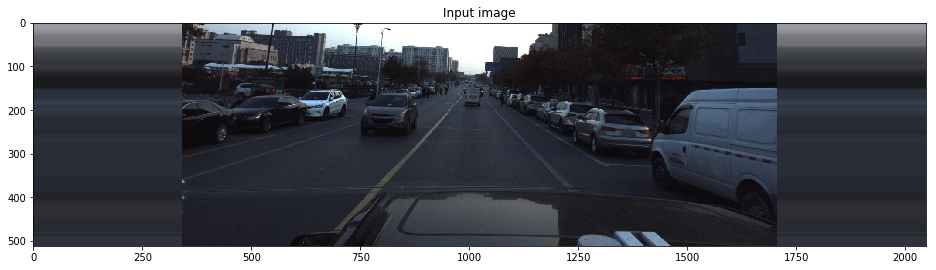

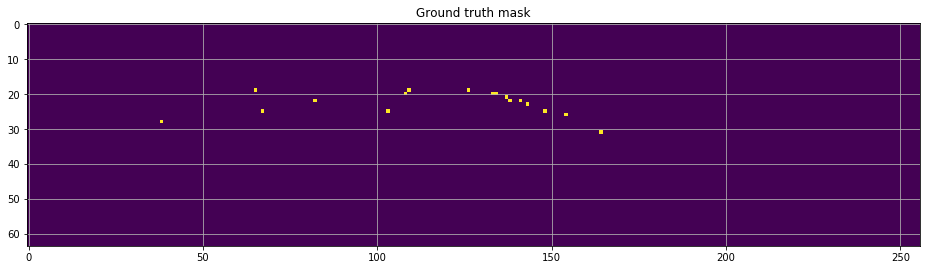

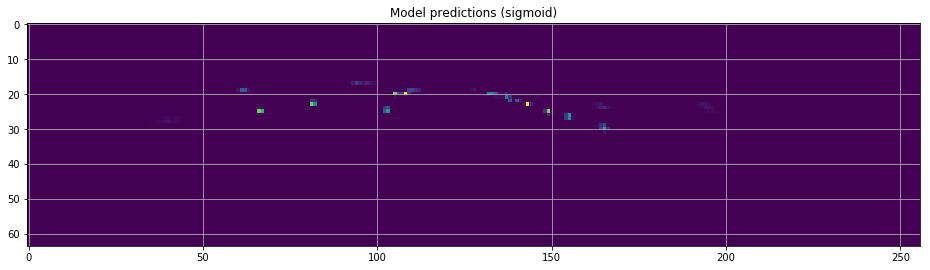

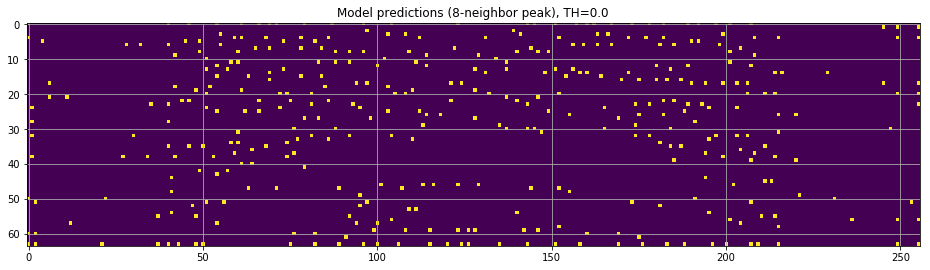

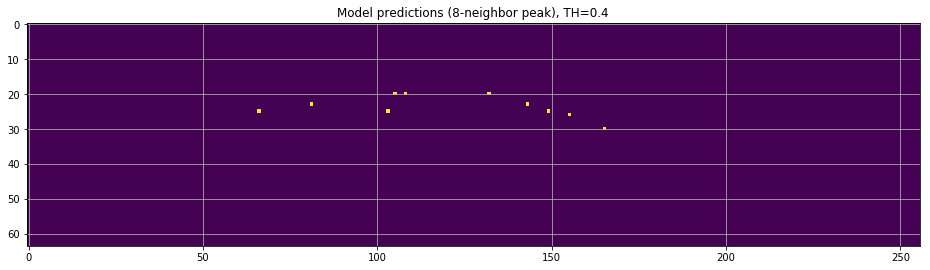

In [43]:
img, mask, regr, ign_mask, ign_mask_for_feed = dev_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.grid()
plt.imshow(mask)
plt.show()

output = infer_image(img[None], ign_mask_for_feed[None])
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions (sigmoid)')
plt.grid()
plt.imshow(sigmoid(logits))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions (8-neighbor peak), TH=0.0')
plt.grid()
plt.imshow(postprocess_heatmap( logits, thresh=0.0 ))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions (8-neighbor peak), TH=0.4')
plt.grid()
plt.imshow(postprocess_heatmap( logits, thresh=0.4 ))
plt.show()

In [44]:
## Simple test of probabilities
act = torch.nn.Sigmoid()
logtens = torch.from_numpy(logits)
probs = act(logtens)
probs = probs[probs>00.00]
print(probs)

tensor([2.1356e-05, 6.4710e-06, 1.3864e-06,  ..., 9.0039e-07, 9.6907e-07,
        3.4083e-06])


In [45]:
import gc
torch.cuda.empty_cache()
gc.collect()

#for idx in range(3):
#    img, heatmap, regr, ign_mask, ign_mask_for_feed = dev_dataset[idx]
#    mask = (heatmap >= 1).astype(float)
#    if False: #debug
#        print(regr.shape)
#        print(heatmap.shape)
#        print( REGR_TARGETS )
#        print(np.where(heatmap == 1))
#        print(np.where(regr[-1] > 0))
#        print(regr[ -1 ][heatmap >= 1] )
#        raise
#    
#    output = infer_image(img[None], ign_mask_for_feed[None])
#    output = output.data.cpu().numpy()
#
#    coords_pred = extract_coords(output[0], ign_mask)
#    
#    perfect_logits = 1000 * ( ( heatmap==1 ).astype(float) - 0.5 )
#    coords_true = extract_coords(np.concatenate([perfect_logits[None], regr], 0), ign_mask)
#    
#    img = read_image(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
#    
#    fig, axes = plt.subplots(1, 2, figsize=(30,30))
#    axes[0].set_title('Ground truth')
#    axes[0].imshow(visualize(img, coords_true))
#    axes[1].set_title('Prediction')
#    axes[1].imshow(visualize(img, coords_pred))
#    plt.show()

11579

# Make submission

In [46]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size= MAKE_SUBMISSION_BATCH_SIZE, shuffle=False, num_workers=4)

model.eval()

for img, _, _, ign_masks, ign_mask_for_feed_batch in tqdm(test_loader):
    with torch.no_grad():
        output = infer_image(img, ign_mask_for_feed_batch)
    
    output = output.data.cpu().numpy()
    
    for out, ign_mask in zip(output, ign_masks):
        coords = extract_coords(out, ign_mask)
        s = coords2str(coords)
        predictions.append(s)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [47]:
test = pd.read_csv(HOMEDIR + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv(OUTDIR + 'predictions.csv', index=False)
test.head()

,ImageId,PredictionString
0,ID_18fb86d04,
1,ID_ce06d4dc1,0.12905625 0.01020941566383812 -3.090875936793...
2,ID_afe07078f,0.13256462 -0.04270014089787201 -3.09947518085...
3,ID_37caf75aa,0.14781325 3.0888124049091052 -3.0930830297344...
4,ID_7655363ca,0.13142446 3.133199376096114 -3.11276065942878...


In [48]:
for _th in [ 0.40, 0.41, 0.45 ]:
    trim_below_threth(test, _th ).to_csv(OUTDIR + f'predictions_threth{_th}.csv', index=False)

## metrics calculation copied from some other notebook

In [49]:
dev_predictions = []

dev_loader = DataLoader(dataset=dev_dataset, batch_size= DEV_PREDICTIONS_BATCH_SIZE, shuffle=False, num_workers=4)

model.eval()

for img, _, _, ign_masks, ign_mask_for_feed_batch in tqdm(dev_loader):
    with torch.no_grad():
        if USEMASK:
            output = infer_image(img, ign_mask_for_feed_batch)
        else:
            output = model(img.to(device))
    output = output.data.cpu().numpy()
    
    for out, ign_mask in zip(output, ign_masks):
        coords = extract_coords(out, ign_mask)
        s = coords2str(coords)
        dev_predictions.append(s)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [50]:
CV_dev = pd.DataFrame()
CV_dev["ImageId"] = df_dev.ImageId.copy()
CV_dev['PredictionString'] = dev_predictions

VAL_PRED_PATH = OUTDIR + "validation_pred.csv"
CV_dev.to_csv(VAL_PRED_PATH, index=False)

CV_dev.head()

,ImageId,PredictionString
3811,ID_121ad7251,0.14875454 3.102294665613358 -3.11606984411413...
2097,ID_b0e70a3a4,0.17010719 -0.0005803624325645449 -3.104199180...
2282,ID_bd9023bd8,0.1479732 0.2143137274547515 -3.10377306689555...
1075,ID_8e5066882,0.131642 -0.06781926362979733 -3.0889794585579...
2176,ID_31b57b829,0.13924992 -0.15898265394774347 -3.09654927824...


In [51]:
mapval = calc_map(CV_dev)

print('map:', mapval)

# save
pd.DataFrame({"val-mAP": [mapval]}).to_csv(OUTDIR + "val-mAP.csv", index=False)

map: 0.062294310722100656


In [52]:
CV_dev

,ImageId,PredictionString
3811,ID_121ad7251,0.14875454 3.102294665613358 -3.11606984411413...
2097,ID_b0e70a3a4,0.17010719 -0.0005803624325645449 -3.104199180...
2282,ID_bd9023bd8,0.1479732 0.2143137274547515 -3.10377306689555...
1075,ID_8e5066882,0.131642 -0.06781926362979733 -3.0889794585579...
2176,ID_31b57b829,0.13924992 -0.15898265394774347 -3.09654927824...
...,...,...
2425,ID_0e8575fa6,0.124623165 3.092102654067171 -3.1070170571380...
3670,ID_96d347b48,0.12412282 3.1052328048399636 -3.1082284470372...
1256,ID_be1706f86,0.12697837 0.04197404232206497 -3.098736366378...
129,ID_cba19338b,0.13655888 2.3286072643510933 -3.1012285669618...


In [53]:
trim_below_threth(CV_dev, 0.45 ) 

,ImageId,PredictionString
3811,ID_121ad7251,0.14875454 3.102294665613358 -3.11606984411413...
2097,ID_b0e70a3a4,0.17010719 -0.0005803624325645449 -3.104199180...
2282,ID_bd9023bd8,0.1479732 0.2143137274547515 -3.10377306689555...
1075,ID_8e5066882,0.131642 -0.06781926362979733 -3.0889794585579...
2176,ID_31b57b829,0.13924992 -0.15898265394774347 -3.09654927824...
...,...,...
2425,ID_0e8575fa6,0.124623165 3.092102654067171 -3.1070170571380...
3670,ID_96d347b48,0.12412282 3.1052328048399636 -3.1082284470372...
1256,ID_be1706f86,0.12697837 0.04197404232206497 -3.098736366378...
129,ID_cba19338b,0.13655888 2.3286072643510933 -3.1012285669618...


In [54]:
#for th in np.arange(0.30, 0.55, 0.025):
for th in np.arange(0.45, 0.55, 0.01):
    mapval = calc_map( trim_below_threth(CV_dev, th) )
    print(f'threth:{th} map:{mapval}')

threth:0.45 map:0.062294310722100656
threth:0.46 map:0.06106061966771441
threth:0.47000000000000003 map:0.0603967690192484
threth:0.48000000000000004 map:0.05918295739348371
threth:0.49000000000000005 map:0.05769751738638201
threth:0.5 map:0.05660864212986146
threth:0.51 map:0.05498180051813471
threth:0.52 map:0.053354968376982004
threth:0.53 map:0.05154657672540382
threth:0.54 map:0.05022211940015185
threth:0.55 map:0.04830772159984277
